In [1]:
import os
os.chdir("C:/Users/ibo.kylegregory/bisaya-stt-module")


In [2]:
import os
import pandas as pd
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# Path to metrics and logs
metrics_file = "docs/validation_metrics.md"
loss_log = "logs/loss_history.csv"


In [3]:
def show_latest_wer():
    if not os.path.exists(metrics_file):
        display(Markdown("⚠️ `validation_metrics.md` not found yet."))
        return
    with open(metrics_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
        if not lines:
            display(Markdown("🟡 No WER data yet."))
            return
        display(Markdown("### 🧾 Latest WER Metrics"))
        display(Markdown("```\n" + "".join(lines[-5:]) + "\n```"))

show_latest_wer()


### 🧾 Latest WER Metrics

```
2025-07-19T10:55:21.774704 - WER: 1.0000
2025-07-19T11:13:52.590278 - WER: 1.0000
2025-07-19T11:32:16.358448 - WER: 1.0000
2025-07-19T11:53:29.262798 - WER: 1.0000

```

C:\Users\ibo.kylegregory\bisaya-stt-module\bisaya-stt-venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


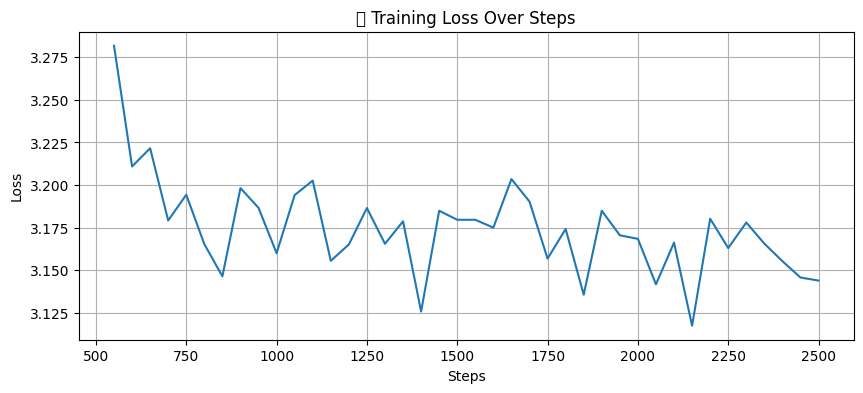

In [4]:
def plot_loss():
    if not os.path.exists(loss_log):
        display(Markdown("⚠️ `loss_history.csv` not found yet."))
        return
    df = pd.read_csv(loss_log)
    if df.empty:
        display(Markdown("🟡 No loss data yet."))
        return
    plt.figure(figsize=(10, 4))
    plt.plot(df["step"], df["loss"])
    plt.title("📉 Training Loss Over Steps")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

plot_loss()


In [5]:
from transformers import Wav2Vec2Processor
from datasets import load_from_disk
import torch

# Constants
DATASET_VERSION = "v1_training_ready_grapheme"
PROCESSOR_VERSION = "v1_grapheme"
MAX_INPUT_LENGTH_SEC = 15

# === Load your processor ===
processor = Wav2Vec2Processor.from_pretrained(
    r"C:\Users\ibo.kylegregory\bisaya-stt-module\processor\v1_grapheme",
    local_files_only=True
)

# === Load dataset ===
raw_dataset = load_from_disk(r"C:\Users\ibo.kylegregory\bisaya-stt-module\data\processed\v1_training_ready_grapheme")
max_len = int(processor.feature_extractor.sampling_rate * MAX_INPUT_LENGTH_SEC)
filtered_dataset = raw_dataset.filter(lambda x: len(x["input_values"]) <= max_len)
dataset = filtered_dataset["train"].train_test_split(test_size=0.1)

# === Sample: Inspect a label sequence ===
sample = dataset["test"][0]  # or adjust index
label_ids = sample["labels"]

# === Convert label IDs to tokens ===
tokens = processor.tokenizer.convert_ids_to_tokens(label_ids)
decoded_text = processor.tokenizer.decode(label_ids, skip_special_tokens=True)

print("🔢 Label IDs:", label_ids)
print("🔡 Tokens:", tokens)
print("📝 Decoded Text:", decoded_text)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


🔢 Label IDs: [28, 26, 31, 26, 44, 38, 36, 18, 44, 28, 18, 44, 35, 18, 31, 21, 32, 30, 44, 31, 24, 18, 44, 30, 24, 18, 44, 37, 26, 31, 38, 30, 33, 18, 24, 6, 44, 31, 18, 28, 26, 37, 5, 18, 31, 44, 31, 18, 28, 32, 44, 36, 18, 44, 18, 28, 32, 31, 24, 44, 20, 18, 35, 33, 22, 37, 6, 44, 40, 18, 29, 18, 44, 28, 32, 44, 28, 18, 25, 26, 19, 18, 29, 32, 44, 28, 38, 31, 24, 44, 38, 31, 36, 18, 44, 18, 31, 24, 44, 24, 26, 28, 18, 32, 31, 44, 36, 18, 44, 37, 18, 40, 32, 6]
🔡 Tokens: ['k', 'i', 'n', 'i', '|', 'u', 's', 'a', '|', 'k', 'a', '|', 'r', 'a', 'n', 'd', 'o', 'm', '|', 'n', 'g', 'a', '|', 'm', 'g', 'a', '|', 't', 'i', 'n', 'u', 'm', 'p', 'a', 'g', '.', '|', 'n', 'a', 'k', 'i', 't', '-', 'a', 'n', '|', 'n', 'a', 'k', 'o', '|', 's', 'a', '|', 'a', 'k', 'o', 'n', 'g', '|', 'c', 'a', 'r', 'p', 'e', 't', '.', '|', 'w', 'a', 'l', 'a', '|', 'k', 'o', '|', 'k', 'a', 'h', 'i', 'b', 'a', 'l', 'o', '|', 'k', 'u', 'n', 'g', '|', 'u', 'n', 's', 'a', '|', 'a', 'n', 'g', '|', 'g', 'i', 'k', 'a', 'o', 'n'

In [7]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from datasets import load_from_disk
import torch
import os

# === Constants ===
MODEL_PATH = "models/wav2vec2/v1_bisaya"
PROCESSOR_PATH = "processor/v1_grapheme"
DATASET_PATH = "data/processed/v1_training_ready_grapheme"
MAX_INPUT_LENGTH_SEC = 15

# === Load model and processor ===
processor = Wav2Vec2Processor.from_pretrained(PROCESSOR_PATH, local_files_only=True)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_PATH, local_files_only=True)
model.eval()

# === Load dataset and sample ===
raw_dataset = load_from_disk(DATASET_PATH)
max_len = int(processor.feature_extractor.sampling_rate * MAX_INPUT_LENGTH_SEC)
filtered_dataset = raw_dataset.filter(lambda x: len(x["input_values"]) <= max_len)
dataset = filtered_dataset["train"].train_test_split(test_size=0.1)

sample = dataset["test"][0]
input_values = torch.tensor([sample["input_values"]])
attention_mask = torch.ones_like(input_values)

# === Predict ===
with torch.no_grad():
    logits = model(input_values).logits

pred_ids = torch.argmax(logits, dim=-1)[0]
pred_tokens = processor.tokenizer.convert_ids_to_tokens(pred_ids)
pred_text = processor.batch_decode(pred_ids.unsqueeze(0))[0]

# === Decode reference ===
ref_text = processor.tokenizer.decode(sample["labels"], skip_special_tokens=True)

# === Output ===
print("📌 Reference Text:", ref_text)
print("🎯 Predicted IDs:", pred_ids.tolist())
print("🔡 Predicted Tokens:", pred_tokens)
print("🧠 Predicted Text:", pred_text)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


OSError: models/wav2vec2/v1_bisaya does not appear to have a file named config.json. Checkout 'https://huggingface.co/models/wav2vec2/v1_bisaya/main' for available files.

In [8]:
from transformers import Wav2Vec2Processor

# Adjust path as needed
processor_path = "./processor/v1_grapheme"
processor = Wav2Vec2Processor.from_pretrained(processor_path)

print("✅ Processor loaded from:", processor_path)
print("🔠 Vocab size:", len(processor.tokenizer))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


✅ Processor loaded from: ./processor/v1_grapheme
🔠 Vocab size: 53


In [9]:
# Simulate a Trainer prediction step
from torch.nn.functional import softmax

logits = torch.tensor(pred.predictions)
pred_ids = torch.argmax(logits, dim=-1)[0]

print("🧠 Raw Predicted IDs:", pred_ids.tolist())
print("🔡 Tokens:", processor.tokenizer.convert_ids_to_tokens(pred_ids))
print("📝 Decoded:", processor.batch_decode([pred_ids])[0])


NameError: name 'pred' is not defined